## Supplementary Figure 10. Reproducibility of SV gene identification algorithms in breast cancer biopsies data. 

In [1]:
from scGCO import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def my_shuffle(data_norm,gene_lists,axis=0):
    data_norm_rand=data_norm.copy()
    if axis==0:
        for i in range(data_norm.shape[0]):
            data_norm_rand.ix[i,gene_lists]=shuffle(data_norm.ix[i,gene_lists]).values
    elif axis==1:
        for i in range(data_norm.shape[1]):
            data_norm_rand.iloc[:,i]=shuffle(data_norm.iloc[:,i]).values
    return data_norm_rand

In [4]:
def visualize_tsne_density_new(tsne_proj, threshold=0.001, bins=100, ax=None,fileName=None,title=None):
    '''
    perform kde density estimationg for tsne projection 
    :param file: tsne_proj: shape (m, 2)
    threshold=0.001, bins=100, fileName=None
    '''   
    #fig, ax = plt.subplots()
    kde = gaussian_kde(tsne_proj.T, bw_method = 'scott')
    z = kde(tsne_proj.T)    
    x = np.ma.masked_where(z > threshold, tsne_proj[:,0])
    y = np.ma.masked_where(z > threshold, tsne_proj[:,1])

    # plot unmasked points
    ax.scatter(tsne_proj[:,0], tsne_proj[:,1], c='black', marker='o', s=5)

    # get bounds from axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # prepare grid for density map
    xedges = np.linspace(xmin, xmax, bins)
    yedges = np.linspace(ymin, ymax, bins)
    xx, yy = np.meshgrid(xedges, yedges)
    gridpoints = np.array([xx.ravel(), yy.ravel()])

    # compute density map
    zz = np.reshape(kde(gridpoints), xx.shape)

    # plot density map
    im = ax.imshow(zz, cmap='Spectral_r', interpolation='nearest',
               origin='lower', extent=[xmin, xmax, ymin, ymax],
                  aspect='auto')
    # plot threshold contour
    cs = ax.contour(xx, yy, zz, levels=[threshold], colors='black', line_width=10)
    # show
    #fig.colorbar(im)
#     plt.title(title,fontname="Arial",fontsize=12)

#     if fileName != None:
#         plt.savefig(fileName)
#     plt.show()
    return im

## Supplementary Figure 10 cde. Kernel density plots of the t-SNE projections random scGCO spatialDE

---------------------analysis Layer1_BC-----------------------------
raw data dim: (254, 14880)
---------------------analysis Layer1_BC done!!!-----------------------
---------------------analysis Layer2_BC-----------------------------
raw data dim: (251, 14789)
---------------------analysis Layer2_BC done!!!-----------------------
---------------------analysis Layer3_BC-----------------------------
raw data dim: (264, 14929)
---------------------analysis Layer3_BC done!!!-----------------------
---------------------analysis Layer4_BC-----------------------------
raw data dim: (262, 14808)
---------------------analysis Layer4_BC done!!!-----------------------


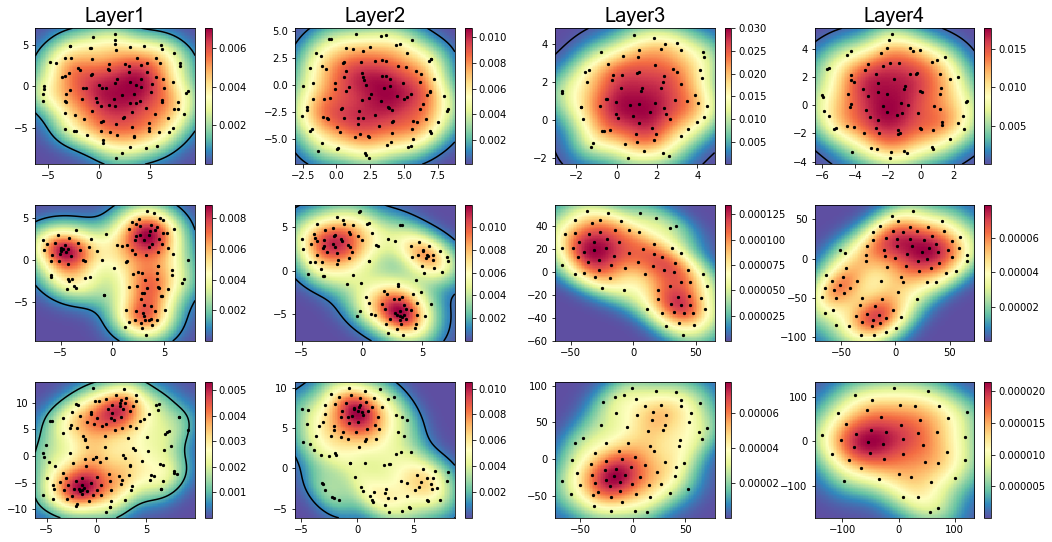

In [5]:
scGCO_list=[]
fig,ax=plt.subplots(3,4,figsize=(16,8))
fig.subplots_adjust(hspace=0.3, wspace=0.3,
                                top=0.925, right=0.925, bottom=0.075, left = 0.075)
                  
for i in range(1,5):
    unary_scale_factor=100
    label_cost=10
    algorithm='expansion'
    
    print ("---------------------analysis Layer"+str(i)+"_BC-----------------------------")
    ff = '../../data/Raw_data/MOB-breast-cancer/Layer' + str(i) +  '_BC_count_matrix-1.tsv'
    
    locs,data=read_spatial_expression(ff,sep='\t')
    data_norm = normalize_count_cellranger(data)

    
    fileName=("../../data/BreastCancer/scGCO_results/Layer"+str(i)+"_BC_result_df.csv")
    result_df=read_result_to_dataframe(fileName)

    fileName=("../../data/BreastCancer/scGCO_results/Layer"+str(i)+"_BC_pattern_conserved_df.csv")
    pattern_conserved_df=read_result_to_dataframe(fileName)

    fileName=("../../data/BreastCancer/scGCO_results/Layer"+str(i)+"_BC_pattern_conserved_df_exp.csv")
    pattern_conserved_df_exp=read_result_to_dataframe(fileName)
    
    # scGCO
    tsne_proj_gene=spatial_pca_tsne(data_norm,pattern_conserved_df_exp.index,
                                                                      perplexity=30)
    im=visualize_tsne_density_new(tsne_proj_gene, threshold=0.001, bins=100, ax=ax[1][i-1])
    fig.colorbar(im,ax=ax[1][i-1])
    
    
    
    #rand
    tsne_proj_gene_rand=spatial_pca_tsne(my_shuffle(data_norm,pattern_conserved_df_exp.index,axis=1),
                                                              pattern_conserved_df_exp.index,perplexity=30)
    im=visualize_tsne_density_new(tsne_proj_gene_rand, threshold=0.001, bins=100, ax=ax[0][i-1])
    fig.colorbar(im,ax=ax[0][i-1])
    ax[0][i-1].set_title("Layer"+str(i),fontname="Arial",fontsize=20)
    
   

    #spatialDE
    results=pd.read_csv("../../data/BreastCancer/spatialDE_results/Layer" + str(i) + "_BC_final_results.csv",index_col=0)
    de_results=results.query('qval <0.05 & g!="log_total_count"').copy()
    genelist=set(de_results.g.values)&set(data_norm.columns)
    
    tsne_proj_gene_spatialde=spatial_pca_tsne(data_norm,genelist,perplexity=30)
    im=visualize_tsne_density_new(tsne_proj_gene_spatialde, threshold=0.001, bins=100, ax=ax[2][i-1])
    fig.colorbar(im,ax=ax[2][i-1])
    print ("---------------------analysis Layer"+str(i)+"_BC done!!!-----------------------") 
    
    
    
    
    
    
    
    scGCO_list+=list(pattern_conserved_df_exp.index.values)
    
fig.savefig("../../figures//Suppl_Figure10cde_BC_random_scGCO_spatialDE_kde.pdf",format="pdf",bbox_inches="tight",dpi=300)



In [6]:
from collections import Counter
scGCO_counts=Counter(scGCO_list)
scGCO_counts_df= pd.DataFrame.from_dict(scGCO_counts, orient='index',columns=["times"])
print(scGCO_counts_df.shape[0])
scGCO_rep=scGCO_counts_df.groupby("times").size()

189


In [7]:
from collections import Counter
spatialDE_list=[]
for i in range(1,5):
    results=pd.read_csv("../../data/BreastCancer/spatialDE_results/Layer" + str(i) + "_BC_final_results.csv",index_col=0)
    de_results=results.query('qval <0.05 & g!="log_total_count"').copy()
    spatialDE_list+=list(de_results.g.values)
spatialDE_counts=Counter(spatialDE_list)
spatialDE_counts_df= pd.DataFrame.from_dict(spatialDE_counts, orient='index',columns=["times"])
print(spatialDE_counts_df.shape[0])
spatialDE_rep=spatialDE_counts_df.groupby("times").size()


263


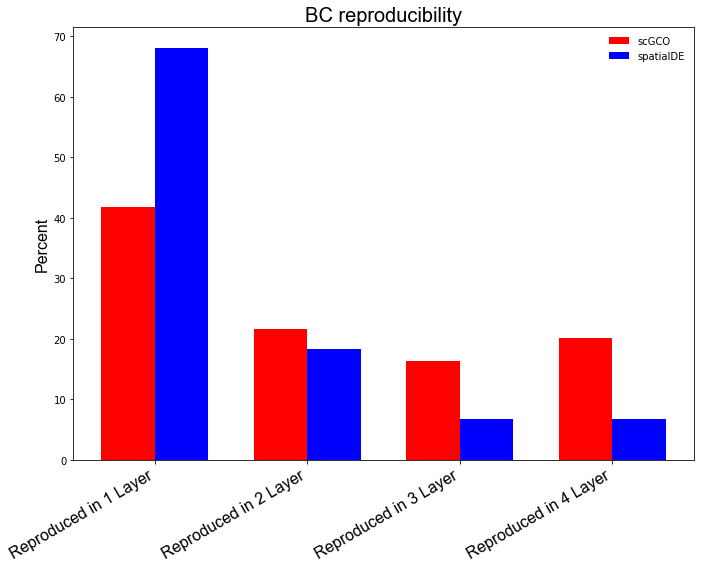

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick


scGCO_arr=scGCO_rep/scGCO_counts_df.shape[0]
spatialDE_arr=spatialDE_rep/spatialDE_counts_df.shape[0]

ind = np.arange(len(scGCO_arr))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(ind - width/2, scGCO_arr, width,color="r",
                label='scGCO')
rects2 = ax.bar(ind + width/2, spatialDE_arr, width, color="b",
                label='spatialDE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent',fontname="Arial",fontsize=16)
ax.set_title('BC reproducibility',fontname="Arial",fontsize=20)
ax.set_xticks(ind)
ax.set_xticklabels(("Reproduced in "+ str(i+1) + " Layer" for i in range(0,4)),rotation=30,horizontalalignment="right",fontname="Arial",fontsize=16)
ax.legend(frameon=False)


# def autolabel(rects, xpos='center'):
#     """
#     Attach a text label above each bar in *rects*, displaying its height.

#     *xpos* indicates which side to place the text w.r.t. the center of
#     the bar. It can be one of the following {'center', 'right', 'left'}.
#     """

#     ha = {'center': 'center', 'right': 'left', 'left': 'right'}
#     offset = {'center': 0, 'right': 1, 'left': -1}

#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(offset[xpos]*3, 3),  # use 3 points offset
#                     textcoords="offset points",  # in both directions
#                     ha=ha[xpos], va='bottom')


# autolabel(rects1, "left")
# autolabel(rects2, "right")

ax.set_yticklabels(['{:.0f}'.format(x*100) for x in ax.get_yticks()]) 


fig.tight_layout()
fig.savefig("../../figures//Suppl_Figures10b_BC_reproducibility.pdf",format="pdf",dpi=300)
plt.show()

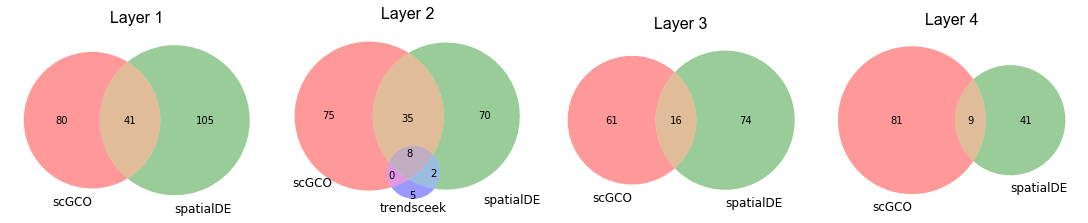

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib_venn import venn2
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
figure, axes = plt.subplots(1, 4, figsize=(15,15), constrained_layout=True)  
gco_brca_res=list()
de_brca_res=list()
sceek_brca_res=list()

for i in np.arange(4)+1:
        gco = "../../data/BreastCancer/scGCO_results/Layer"+str(i)+"_BC_pattern_conserved_df_exp.csv"
        counts_gco = read_result_to_dataframe(gco)
        gco_brca_res.append(counts_gco.shape[0])
        
        de = "../../data/BreastCancer/spatialDE_results/Layer" + str(i) + "_BC_final_results.csv"
        counts_de = pd.read_csv(de,index_col=0)
        counts_de=counts_de[counts_de.qval<0.05]
        counts_de=counts_de[counts_de.g.values != 'log_total_count']
        de_brca_res.append(counts_de.shape[0])
        x = int((i-1)/4)
        y= (i-1) % 4
        titleText = 'Layer ' + str(i)
        counts_sceek=pd.read_csv("../../data/BreastCancer/trendsceek_results/BC2_sig_gene_list.csv",index_col=0)
        if i !=2:
            venn2(subsets=[set(counts_gco.index.values), 
                        set(counts_de.g.values)],
                        set_labels = ('scGCO', 'spatialDE'),                     
                        ax=axes[y])
            sceek_brca_res.append(0)
        else:
            vn=venn3(subsets=[set(counts_gco.index.values), 
                           set(counts_de.g.values),
                           set(counts_sceek.sig_gene.values)],
                           set_labels = ('scGCO', 'spatialDE',"trendsceek"),                     
                           ax=axes[y])
            sceek_brca_res.append(counts_sceek.shape[0])
            lbl_A= vn.get_label_by_id("A")
            xx, yy = lbl_A.get_position()
            lbl_A.set_position((xx, yy-0.85)) 
            
            lbl_B= vn.get_label_by_id("B")
            xx, yy = lbl_B.get_position()
            lbl_B.set_position((xx, yy-0.95)) 
        ax = axes[y]
        ax.set_title(titleText, fontname="Arial", fontsize=16)

plt.savefig("../../figures//Suppl_Figure10a_Layer_BC_scGCO_vs_spatialDE_vs_trendsceek.pdf",format="pdf",dpi=300)
plt.show()

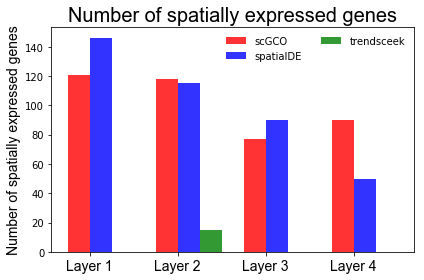

In [11]:
n_groups = 4
means_scGCO = gco_brca_res
means_spatialDE = de_brca_res
means_trendsceek= sceek_brca_res

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, means_scGCO, bar_width,
                 alpha=opacity,
                 color='r',
                 label='scGCO')
 
rects2 = plt.bar(index + bar_width, means_spatialDE, bar_width,
                 alpha=opacity,
                 color='b',
                 label='spatialDE')

rects3=plt.bar(index + 2*bar_width, means_trendsceek, bar_width,
                 alpha=opacity,
                 color='g',
                 label='trendsceek')

plt.xlabel('')
plt.ylabel('Number of spatially expressed genes',fontname="Arial",fontsize=14)
plt.title('Number of spatially expressed genes',fontname="Arial",fontsize=20)
plt.xticks(index,["Layer "+ str(i+1) + " Rep" for i in range(0,4)],fontname="Arial",fontsize=14)
glabel = list()
for i in np.arange(4)+1:
    temp = 'Layer '+str(i)
    glabel.append(temp)
plt.xticks(index + bar_width/2, glabel)
plt.legend(loc='upper right',frameon=False,ncol=2)
 
plt.tight_layout()
plt.savefig("../../figures//Layer_BC_scGCO_vs_spatialDE_vs_trendsceek_barchart.pdf",format="pdf",dpi=300)
plt.show()

In [12]:
gco_series = pd.Series(gco_brca_res)   
# calling .mad() method 
gco_mad= gco_series.mad() 
print("scGCO MAD: {}".format(gco_mad))

de_series = pd.Series(de_brca_res)   
# calling .mad() method 
de_mad= de_series.mad() 
print("saptialDE MAD: {}".format(de_mad))

scGCO MAD: 18.0
saptialDE MAD: 30.25


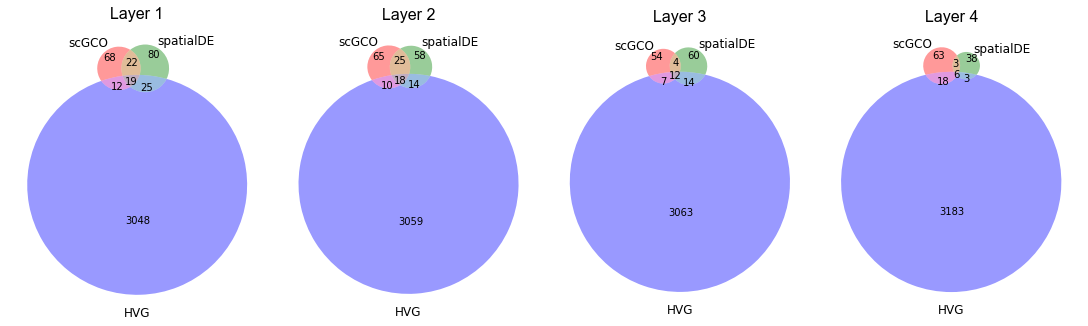

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib_venn import venn2
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
figure, axes = plt.subplots(1, 4, figsize=(15,15), constrained_layout=True)  
for i in np.arange(4)+1:
        fileName=("../../data/BreastCancer/scGCO_results/Layer"+str(i)+"_BC_pattern_conserved_df_exp.csv")
        pattern_conserved_df_exp=read_result_to_dataframe(fileName)
        
        de = "../../data/BreastCancer/spatialDE_results/Layer" + str(i) + "_BC_final_results.csv"
        counts_de = pd.read_csv(de,index_col=0)
        counts_de=counts_de[counts_de.qval<0.05]
        counts_de=counts_de[counts_de.g.values != 'log_total_count']
        x = int((i-1)/4)
        y= (i-1) % 4
        titleText = 'Layer ' + str(i)
        hvg_df=pd.read_csv("../../data/HighVariableGenes/BC_layers"+ str(i) + "_hvgs.csv",header=None,index_col=0)
        if True:
#             venn2(subsets=[set(counts_gco.index.values), 
#                         set(counts_de.g.values)],
#                         set_labels = ('scGCO', 'spatialDE'),                     
#                         ax=axes[x][y])
#         else:
            vn=venn3(subsets=[set(pattern_conserved_df_exp.index.values), 
                           set(counts_de.g.values),
                           set(hvg_df.index)],
                           set_labels = ('scGCO', 'spatialDE',"HVG"),                     
                           ax=axes[y])
#             lbl_A= vn.get_label_by_id("A")
#             xx, yy = lbl_A.get_position()
#             lbl_A.set_position((xx, yy-0.85)) 
            
#             lbl_B= vn.get_label_by_id("B")
#             xx, yy = lbl_B.get_position()
#             lbl_B.set_position((xx, yy-0.95)) 
        ax = axes[ y]
        ax.set_title(titleText, fontname="Arial", fontsize=16)
plt.savefig("../../figures//Layer_BC_scGCO_vs_spatialDE_vs_HVG_seruat.pdf",format="pdf",dpi=300)
plt.show()